In [1]:
%matplotlib inline
import torch, torchvision
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import copy
import numpy as np
from torch.utils.data import Dataset
import requests
from io import BytesIO
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import d2l_torch as d2l

In [2]:
TRAIN_PATH = "../data/kaggle_dog_cat/train/" # 10000 cats & 10000 dogs
# VAL_PATH = "./data/kaggle-dog-cat/val" # 2500 cats & 2500 dogs extracted from train folder
# NUM_BATCH = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data = os.listdir(TRAIN_PATH)

In [4]:
df = pd.DataFrame(data)

In [5]:
train_img_label, val_img_label = train_test_split(df, test_size=0.3)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 采用 matplotlib 展示图片
image = mpimg.imread('../data/kaggle_dog_cat/train/cat.16.jpg')
plt.imshow(image)

In [7]:
len(train_img_label)

17500

In [8]:
train_img_label.iloc[0].values[0]

'dog.3881.jpg'

In [9]:
transform = transforms.Compose([
    ToTensor(),
    Resize((500,500))
])

In [10]:
class CatDogDataset(Dataset):

    def __init__(self, train_dir, img_label, transform = None):
        
        self.img_label = img_label
        self.transform = transform
        self.train_dir = train_dir
        

    def __len__(self):
        return len(self.img_label)
    
    def __getitem__(self, index):
        entity = self.img_label.iloc[index].values[0]
        image_path = os.path.join(self.train_dir, entity)
        label = entity.split(".")[0]
        label = 0 if label == 'cat' else 1
        image = np.array(Image.open(image_path))
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [11]:
def validate(model, data):

    total = 0
    correct = 0

    for (images, labels) in data:
        images = images.to(DEVICE)
        x = model(images)
        _, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)

    return correct*100/total

In [12]:
def train(num_epoch, lr , device):
    accuracies = []
    cnn = model.to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)

    max_accuracy = 0

    for epoch in range(num_epoch):
        for i, (images, labels) in tqdm(enumerate(train_dl)):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn,val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("saving best model with accuracy: ", accuracy)
        print("Epoch: ", epoch+1, "Accuracy: ", accuracy, "%")

    return best_model


In [13]:
def train_baba(net, train_iter, test_iter, num_epochs, lr):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
            
    def accuracy(y_hat, y):
        return (y_hat.argmax(1) == y).sum()
    
    model_dir = '../data/kaggle_dog_cat/model/'
    model_path = os.path.join(model_dir, 'ResNet18_CatDog_%s.pth'% (num_epochs))
    print('model_path:',model_path)
    net.apply(init_weights)
    net =net.to('cuda:0')
    # print(net)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_detail = pd.DataFrame(columns=['train_loss','test_loss', 'train acc', 'test acc'])
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train_loss','test_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_loss_tot, test_acc_tot, test_tot = 0, 0, 0
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to('cuda:0'), y.to('cuda:0')
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss_tot += l * X.shape[0]
                train_acc_tot += accuracy(y_hat, y)
                train_tot += X.shape[0]
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to('cuda:0'), y.to('cuda:0')
                y_hat = net(X)
                test_loss_tot += l * X.shape[0]
                test_acc_tot += accuracy(y_hat, y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        # print((train_loss.cpu(),test_loss.cpu(), train_acc.cpu(), test_acc.cpu()))
        animator.add(epoch + 1, (train_loss.cpu(),test_loss.cpu(), train_acc.cpu(), test_acc.cpu()))
        train_detail.loc[len(train_detail)] = [train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()]
        torch.save(net.state_dict(), model_path)
        train_detail.to_csv(os.path.join(model_dir, 'train_detail_%s.csv'% (num_epochs)), index=False)

In [14]:
def get_data_loader(NUM_BATCH):
    train_data = CatDogDataset(TRAIN_PATH, train_img_label,  transform)
    val_data = CatDogDataset(TRAIN_PATH, val_img_label,  transform)
    train_dataloader = DataLoader(train_data, batch_size=NUM_BATCH)
    test_dataloader = DataLoader(val_data, batch_size=NUM_BATCH)
    return train_dataloader, test_dataloader

In [15]:
train_dataloader, test_dataloader = get_data_loader(64)

In [16]:
print(torch.cuda.is_available())

True


In [17]:
def infer(pred_iter):
    model = torchvision.models.resnet18(num_classes=2)
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
        
    model.apply(init_weights)
    model.load_state_dict(torch.load('../data/kaggle_dog_cat/model/ResNet18_CatDog_20.pth', weights_only=True))
    model = model.to('cuda:0')
    model.eval()  # 设置模型为推理模式
    prediction = []
    for X, y in pred_iter:
        X, y = X.to('cuda:0'), y.to('cuda:0')
        print(X.shape)
        y_hat = model(X)
        print(y)
        print(y_hat)
        print(y_hat.argmax(1).cpu())
        break
        
        # X = X.to('cuda:0')
        # prediction.extend(train_labels_header[net(X).argmax(1).cpu()])
    # test_data['label'] = prediction
    # test_data.to_csv(os.path.join(data_dir, 'submission.csv'), index=None)

In [18]:
infer(test_dataloader)

torch.Size([64, 3, 500, 500])
tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
tensor([[  4.6727,  -4.3385],
        [  2.7998,  -2.5963],
        [  6.7159,  -6.2729],
        [ -3.0618,   3.0332],
        [  4.3075,  -3.9793],
        [ -1.1667,   1.5544],
        [  9.8589,  -9.1075],
        [  1.3493,  -1.0437],
        [  1.0307,  -0.9165],
        [ -0.2161,   0.2248],
        [  5.7373,  -5.4588],
        [ -4.1776,   4.6399],
        [  1.6739,  -1.3410],
        [ -5.4302,   5.8684],
        [  5.4232,  -5.0807],
        [ -7.4295,   8.0654],
        [  8.2974,  -7.6296],
        [ -3.8268,   4.3061],
        [ -5.6446,   6.1176],
        [  2.2766,  -2.0492],
        [ -0.5683,   0.8685],
        [  1.2847,  -1.1500],
        [  3.5305,  -3.0607],
        [  5.7844,  -5.3469],
        [  6.579

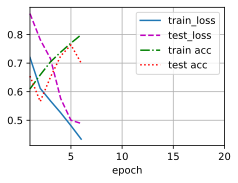

In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-3
net = torchvision.models.resnet18(num_classes=2)
train_baba(net=net, train_iter=train_dataloader, test_iter=test_dataloader,num_epochs=EPOCHS, lr=LEARNING_RATE)